In [29]:
import matplotlib.pyplot as plt
import pickle
import numpy as np
import joblib
import h5py
import joblib
from tqdm import tqdm
from scipy.stats import zscore, ttest_1samp, pearsonr
from sklearn.linear_model import LinearRegression
from statsmodels.stats.anova import AnovaRM 
import pandas as pd

In [2]:
story_dict = joblib.load('Preprocessing/pickle/hipp_storydict_ISC_36_80.sav')

story_lens = pickle.load(open('Preprocessing/pickle/story_lens36.pickle', 'rb'))
event_lens = pickle.load(open('Preprocessing/pickle/event_lens36.pickle', 'rb'))
ev_bounds = pickle.load(open('Preprocessing/pickle/ev_bounds36.pickle', 'rb'))
listen_order = pickle.load(open('Preprocessing/pickle/listen_order36.pickle', 'rb'))
timing = pickle.load(open('Preprocessing/pickle/timing36.pickle', 'rb'))
target_TRs = pickle.load(open('target_TRs.pickle', 'rb'))

In [3]:
prime_names = ['np', 'soc', 'loc']
bound_types = ['social', 'location']

win_size = 20
triggered = np.zeros((2, 36, 3, 2, 4, 2*win_size)) # bounds/target, subj, priming, bound_type, 4 exemplars, window
hrf_shift = 5
hipp_boost = np.zeros((2, 36, 3, 2)) # bounds/target, subj, priming, bound_type
for sub_i, sub in enumerate(listen_order):
    prime_exemplars = np.zeros(3)
    for run in listen_order[sub]:
        for i in range(listen_order[sub][run].shape[0]):
            story = int(listen_order[sub][run][i][1])
            prime = int(listen_order[sub][run][i][2])
            hipp = zscore(story_dict[story][sub_i].mean(0))

            for bound_type_i, bound_type in enumerate(bound_types):
                for analysis_type in range(2):
                    if analysis_type == 0:
                        bounds = ev_bounds[story]['ISC'][bound_type][1:-1]-hrf_shift
                    else:
                        bounds = target_TRs[story][bound_type]-hrf_shift
                    
                    bound_diff = np.add.outer(np.arange(len(hipp)),-1*bounds)
                    peri_bound = np.any((bound_diff >= 0)*(bound_diff <= hrf_shift), axis=1)
                    hipp_boost[analysis_type, sub_i, prime, bound_type_i] += hipp[peri_bound].mean()/4 # 4 stories of each prime type

                    for b in bounds:
                        window = np.minimum(np.maximum([b-win_size, b+win_size],0), len(hipp)-1)
                        triggered[analysis_type, sub_i, prime, bound_type_i, int(prime_exemplars[prime]), (window[0]-b+win_size):(window[1]-b+win_size)] += \
                            hipp[window[0]:window[1]]/len(bounds)/4 # 4 stories of each prime type
            prime_exemplars[prime] += 1

In [4]:
for analysis_type in range(2):
    print(ttest_1samp(hipp_boost[analysis_type,:,:,:].mean(2).mean(1), 0,alternative='greater'))
    
    df = pd.DataFrame(columns=["sub_id", "prime", "type", "boost"])
    row = 0
    for s in range(36):
        for prime_i, prime in enumerate(prime_names):
            for bound_type_i, bound_type in enumerate(bound_types):
                df.loc[row] = [s, prime, bound_type, hipp_boost[analysis_type, s, prime_i, bound_type_i]]
                row += 1

    aovrm = AnovaRM(df, 'boost', 'sub_id', within=['prime', 'type'])
    print(aovrm.fit())

Ttest_1sampResult(statistic=1.8802758003554976, pvalue=0.03420684620485508)
                 Anova
           F Value Num DF  Den DF Pr > F
----------------------------------------
prime       1.4944 2.0000 70.0000 0.2315
type        7.3736 1.0000 35.0000 0.0102
prime:type  0.7651 2.0000 70.0000 0.4691

Ttest_1sampResult(statistic=3.620083443505679, pvalue=0.00046108024976213995)
                 Anova
           F Value Num DF  Den DF Pr > F
----------------------------------------
prime       0.2431 2.0000 70.0000 0.7849
type        0.0468 1.0000 35.0000 0.8300
prime:type  0.5617 2.0000 70.0000 0.5728



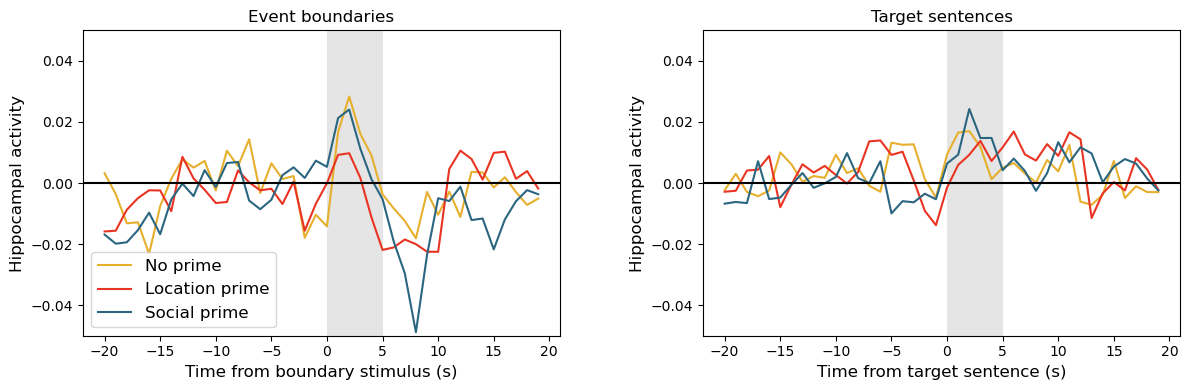

In [5]:
plt.figure(figsize=(12,4))
for analysis_type in range(2):
    plt.subplot(1,2,analysis_type+1)
    priming_colors = ["#E6AF2E", "#2B6681", "#E93423"]
    for p in [0,2,1]:
        plt.plot(np.arange(-1*win_size, win_size),np.nanmean(np.nanmean(np.nanmean(triggered[analysis_type,:,p,:,:,:],2),1),0).T, color=priming_colors[p])
    if analysis_type == 0:
        plt.title('Event boundaries')
        plt.legend(['No prime','Location prime','Social prime'],  fontsize=12, loc='lower left')
        plt.xlabel('Time from boundary stimulus (s)', fontsize=12)
    else:
        plt.title('Target sentences')
        plt.xlabel('Time from target sentence (s)', fontsize=12)
        
    plt.ylabel('Hippocampal activity', fontsize=12)
    
    ylims = 0.05
    rect = plt.Rectangle((0, -1.5*ylims), 5, 3*ylims,
                     facecolor="black", alpha=0.1)
    plt.gca().add_patch(rect)
    plt.ylim(-1*ylims, ylims)
    plt.axhline(c='k')
plt.tight_layout()
plt.subplots_adjust(wspace=0.3)